Базирано на [примерите в документацията](https://www.tensorflow.org/tutorials/text/text_generation) на Tensorflow.

In [1]:
import tensorflow as tf

import numpy as np
import os
import time

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
 tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
with open('page_revisions_text', 'rb') as text_file:
    data = text_file.read()
    
articles = data.split(b'\0')

print('Nummber of articles:', len(articles))
print('Nummber of characters in articles:', sum(len(a) for a in articles))

Nummber of articles: 243427
Nummber of characters in articles: 887891160


In [5]:
first_articles = '. '.join(a.decode('utf-8') for a in articles[:300])
del data

In [6]:
# The unique characters in the file
vocab = sorted(set(first_articles))
print ('{} unique characters'.format(len(vocab)))

1113 unique characters


In [7]:
char2idx = {u: i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in first_articles])

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [8]:
seq_length = 100
examples_per_epoch = len(first_articles) // (seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [9]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [10]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int32, tf.int32)>

In [11]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [12]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),
    tf.keras.layers.GRU(rnn_units, return_sequences=True, stateful=True, recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [13]:
model = build_model(
  vocab_size = len(vocab),
  embedding_dim=embedding_dim,
  rnn_units=rnn_units,
  batch_size=BATCH_SIZE)

In [14]:
for input_example_batch, target_example_batch in dataset.take(1):
  example_batch_predictions = model(input_example_batch)
  print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 1113) # (batch_size, sequence_length, vocab_size)


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           284928    
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 1113)          1140825   
Total params: 5,364,057
Trainable params: 5,364,057
Non-trainable params: 0
_________________________________________________________________


In [16]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [17]:
sampled_indices

array([ 890,  512,  190,  148,  659,  423,  681,  491,  750,  558,    9,
        482,  260, 1104,  722,  333,  280,  321, 1066,  182,  183,  140,
        631, 1027,  105,  571,  299,  507,  466,  383,  878,  637,  901,
        696,  750,  290,  197,  770,  255,   98,  578, 1013,  109,  606,
        332,  484,   98,  958,  829, 1041,  858,  818,  880,  234,  934,
        232,  169,    1,  457, 1110, 1039, 1085,  837,  918,  197,  340,
        336,  184,  689,  295,  440, 1029,  951,  283,  166,  124,  824,
        111,  820,  771,  381, 1051, 1064, 1066,  912,  304,   71,   48,
        417,  355,  399,  565,  447,  802,  936,  815,  489,  921, 1107,
        525], dtype=int64)

In [18]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 " with autism'' can be used instead. This is referred to as ''[[person-first terminology]]''. The [[a"

Next Char Predictions: 
 "林ோūóệा’ணビย'அВ프ガזдլ오ńōëᐅ링³ิчுઆه无ᒃ河\u3000ビоžーϊ£โ도ºსוஎ£術多북庄园昧β素ίę\nি호베카子瑟žםיő→уড메草зē×基À地一م쇼업오烈ьeNयآंหব午罕喜ஜ画해ಶ"


In [19]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 1113)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       7.0161896


In [20]:
model.compile(optimizer='adam', loss=loss)

In [21]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [22]:
EPOCHS=10

In [23]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Train for 319 steps
Epoch 1/10
319/319 [==============================] - 17s 52ms/step - loss: 2.7668
Epoch 2/10
319/319 [==============================] - 16s 51ms/step - loss: 2.0073
Epoch 3/10
319/319 [==============================] - 16s 51ms/step - loss: 1.7013
Epoch 4/10
319/319 [==============================] - 16s 51ms/step - loss: 1.5506
Epoch 5/10
319/319 [==============================] - 16s 51ms/step - loss: 1.4589
Epoch 6/10
319/319 [==============================] - 17s 52ms/step - loss: 1.3928
Epoch 7/10
319/319 [==============================] - 16s 51ms/step - loss: 1.3389
Epoch 8/10
319/319 [==============================] - 16s 51ms/step - loss: 1.2934
Epoch 9/10
319/319 [==============================] - 16s 50ms/step - loss: 1.2534
Epoch 10/10
319/319 [==============================] - 16s 51ms/step - loss: 1.2179


In [24]:
history = model.fit(dataset, epochs=20, callbacks=[checkpoint_callback])

Train for 319 steps
Epoch 1/20
319/319 [==============================] - 16s 52ms/step - loss: 1.1855
Epoch 2/20
319/319 [==============================] - 16s 50ms/step - loss: 1.1576
Epoch 3/20
319/319 [==============================] - 16s 52ms/step - loss: 1.1306
Epoch 4/20
319/319 [==============================] - 16s 50ms/step - loss: 1.1066
Epoch 5/20
319/319 [==============================] - 16s 50ms/step - loss: 1.0853
Epoch 6/20
319/319 [==============================] - 16s 50ms/step - loss: 1.0656
Epoch 7/20
319/319 [==============================] - 16s 51ms/step - loss: 1.0485
Epoch 8/20
319/319 [==============================] - 16s 50ms/step - loss: 1.0323
Epoch 9/20
319/319 [==============================] - 16s 50ms/step - loss: 1.0177
Epoch 10/20
319/319 [==============================] - 16s 51ms/step - loss: 1.0049
Epoch 11/20
319/319 [==============================] - 16s 51ms/step - loss: 0.9939
Epoch 12/20
319/319 [==============================] - 16s 51ms/s

In [25]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints\\ckpt_20'

In [26]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)

model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

model.build(tf.TensorShape([1, None]))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            284928    
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 1113)           1140825   
Total params: 5,364,057
Trainable params: 5,364,057
Non-trainable params: 0
_________________________________________________________________


In [28]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 1000

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
      predictions = tf.squeeze(predictions, 0)

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated))

In [29]:
print(generate_text(model, start_string=u"Anarchy"))

Anarchy_Australia&issue_>A&Austus Nomias'')  (notable, the range systems are usually) of power. John Galt and the events were treating the choice of ethane and the two goals. Nearl euroely in the [[Central Alberta movement being a ge lavy resisting use striped be due to in general in it.
} [http://www.nps.gov/Netrongo George B.  (style="text-align: left" | Mouse committees; without actual territory in places which were founded by cast our [[algaring meter]]s. He comparts divided the establish reference to the fertility.  If a brhy than these beliefs (3864-643)
* ''nartheated'' ("We the [[Lophophologynon]] source of componation -->
  image_cat work controversied oostrialism, from the interpower of collinisible for most. [[sugar]] backwith the South Charlest [[Johann Wolverbility]]. 

Agassi will be set used for generations.  Officially even behive of the molecular western partner who protested purpotable affected by the name, at an one persugue population.  The [[Illyria]], Barma Naza a

In [30]:
def predict_chars(model, start_string):
  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Here batch size == 1
  model.reset_states()

  predictions = model(input_eval)
  predictions = tf.squeeze(predictions, 0)
    
  return predictions

logit_predictions = predict_chars(model, 'Albania')
prediction = tf.nn.softmax(logit_predictions[-1])

In [31]:
sum(prediction).numpy()

0.9999985

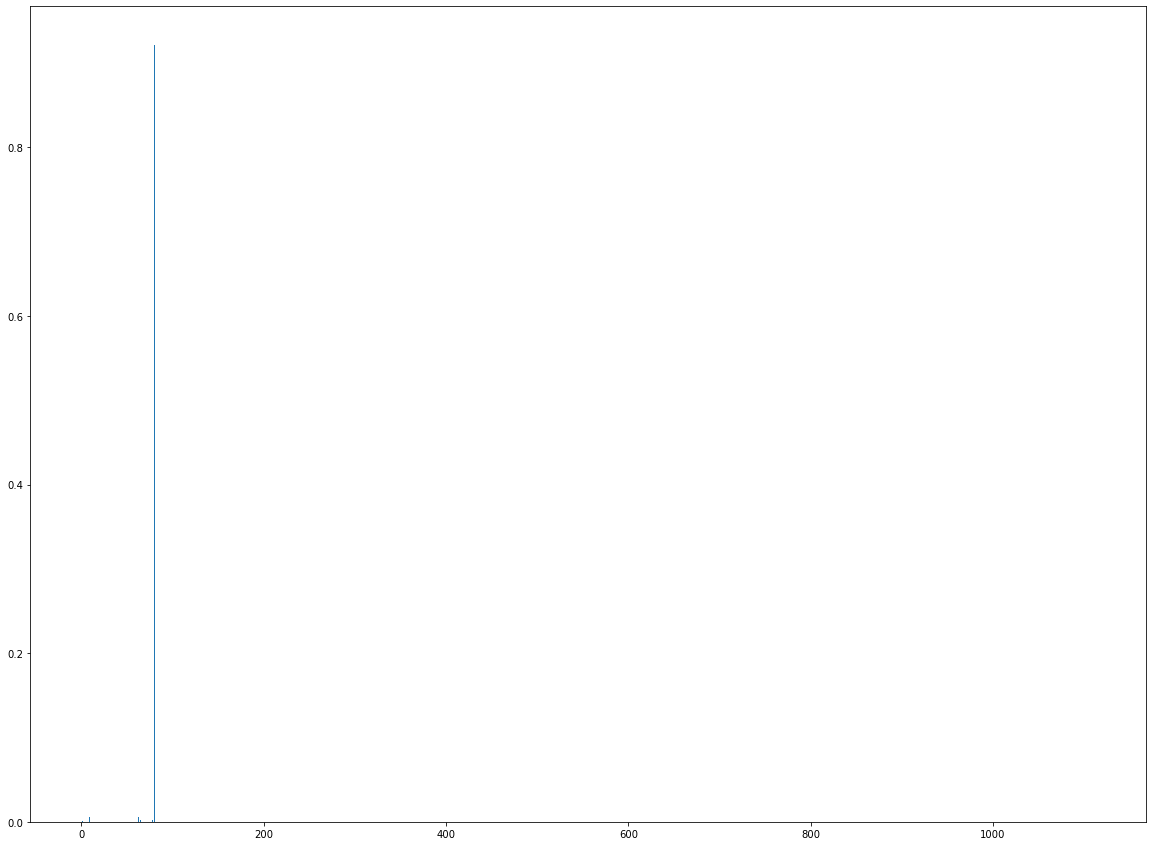

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
plt.bar(range(len(prediction)), prediction);

In [33]:
[[idx2char[index], tensor.numpy()] for index, tensor in enumerate(prediction) if tensor.numpy() > .02]

[['.', 0.04266938], ['n', 0.9212398]]

In [34]:
import huffman

In [35]:
huffman.codebook([idx2char[index], tensor.numpy()] for index, tensor in enumerate(prediction))

{'\t': '0001000001100110100001001',
 '\n': '00010010',
 ' ': '0011',
 '!': '000100000101',
 '"': '000100110010',
 '#': '00010001001100011',
 '$': '000100010011100100000000000',
 '%': '000100000110010',
 '&': '000100010001',
 "'": '0000',
 '(': '0001000001100010',
 ')': '00010011000',
 '*': '0001001100110100',
 '+': '000100011011110010',
 ',': '000101',
 '-': '0001000101',
 '.': '01',
 '/': '00010001100',
 '0': '0001000100111010',
 '1': '000100000110000',
 '2': '0001000100111110001',
 '3': '000100010011010',
 '4': '00010001001100001100',
 '5': '0001000110110011001',
 '6': '000100010011111110',
 '7': '0001000100111001111',
 '8': '0001001100111',
 '9': '00010001001110111',
 ':': '0001000100000',
 ';': '000100000100',
 '<': '000100110011001',
 '=': '0001000000',
 '>': '0001000110111111000000',
 '?': '000100000111',
 '@': '000100110011010111001000',
 'A': '000100011011100',
 'B': '0001000110111111000101',
 'C': '000100010011111101',
 'D': '00010000101',
 'E': '0001001100110101110001',
 'F':

In [36]:
article = articles[120].decode('utf-8')
len(article)

25524

In [46]:
def huffman_archive_size(model, text):
    archived_size = 0
    ones = 0
    input_eval = [char2idx[s] for s in ' ']
    input_eval = tf.expand_dims(input_eval, 0)
  
    # Empty string to store our results
    text_generated = []

    model.reset_states()

    for character in text:
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)
  
        probabilities = tf.nn.softmax(predictions[0])
        codebook = huffman.codebook([index, tensor.numpy()] for index, tensor in enumerate(probabilities))

        code = codebook[char2idx[character]]
        ones += code.count('1')
        archived_size += len(code)

        # using a categorical distribution to predict the character returned by the model
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        input_eval = tf.expand_dims([char2idx[character]], 0)
  
    return ones, archived_size

ones, archived_size = huffman_archive_size(model, article)
print('\nTotal length:', archived_size)


Total length: 42951


Нека видим каква компресия сме постигнали по-дълъг текст:

In [51]:
compression_ratio = archived_size / (len(article) * 8)
compression_ratio

0.21034614480488953

In [54]:
k = (ones / archived_size)
compression_ratio * (-k * np.log2(k) - (1-k) * np.log2(1-k))

0.18468676224448163

In [55]:
0.18468676224448163 * 888

164.00184487309969